## Code for inference using my Model's API

### Imports

In [80]:
import requests
import cv2
import matplotlib.pyplot as plt
import json
from PIL import Image
import io
import random
import re

In [ ]:
color_map = ['FF6F61','FFA500','FFD700', '32CD32', '20B2AA', '1E90FF', '6A5ACD', 'FF1493', 'FF4500', '2E8B57']

### Process Prediction Functions

In [ ]:
def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [ ]:
def process_prediction_results(json_response):
    try:
        results = json.loads(json_response['results'])
        return results
    except Exception as e:
        print(f"Error processing results: {e}")
        return None

In [78]:
def draw_predictions(image, predictions, text_position='above'):
    img_copy = image.copy()

    for pred in predictions:
        name = pred['name']
        name = re.sub(r'\(.*?\)', '', name).strip()
        conf = pred['confidence']
        box = pred['box']
        cls = pred['class']

        # Convert coordinates to integers
        x1, y1 = int(box['x1']), int(box['y1'])
        x2, y2 = int(box['x2']), int(box['y2'])

        # Get color for this plant
        color = hex_to_rgb(color_map[cls])

        # Create label text
        label = f"{name} {conf:.2f}"

        # Get text size
        (text_width, text_height), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)

        # Determine text position
        if text_position == 'above':
            text_y = max(y1 - 5, text_height + 5)
            rect_y1 = text_y - text_height - 4
            rect_y2 = text_y + 2
            text_pt_y = text_y - 2
        else:  # below
            text_y = min(y2 + text_height + 5, image.shape[0] - 5)
            rect_y1 = text_y - text_height - 2
            rect_y2 = text_y + 4
            text_pt_y = text_y

        # Draw colored background for text
        cv2.rectangle(img_copy,
                     (x1, rect_y1),
                     (x1 + text_width + 4, rect_y2),
                     color, -1)

        # Add text in white
        cv2.putText(img_copy, label,
                    (x1 + 2, text_pt_y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4, (255, 255, 255), 1)

        # Draw bounding box
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 1)

    return img_copy

In [66]:
def predict_plant(image_path, text_position='above', api_url="https://coralengel-plant-recognition-api.hf.space/predict"):
    # Read and resize the image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (224, 224))  # Smaller size

    # Convert to RGB
    image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # Convert to bytes
    img_byte_arr = io.BytesIO()
    pil_image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    files = {
        'file': ('image.jpg', img_byte_arr, 'image/jpeg')
    }

    try:
        response = requests.post(api_url, files=files)
        response.raise_for_status()

        predictions = process_prediction_results(response.json())
        if predictions:
            result_image = draw_predictions(image_rgb, predictions, text_position)

            # Display single image
            plt.figure(figsize=(3, 3))
            plt.imshow(result_image)
            plt.axis('off')
            plt.show()

        return predictions
    except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
        return None

### Download images

In [90]:
!wget https://horizonvets.com/wp-content/uploads/2024/02/aloe-vera-white-pot_sunwand24-ss_edit_0.jpg -O aloe_vera.jpg
!wget https://peppyflora.com/wp-content/uploads/2020/12/Hybrid-Peace-Lily-3x4-Product-Peppyflora-01-b-Moz.jpg -O peace_lily.jpg
!wget https://assets.architecturaldigest.in/photos/6347f681575102c76fa2bab5/16:9/w_1920,c_limit/Monstera%20Deliciosa.jpg -O monstera_deliciosa.jpg

--2025-02-08 00:21:35--  https://horizonvets.com/wp-content/uploads/2024/02/aloe-vera-white-pot_sunwand24-ss_edit_0.jpg
Resolving horizonvets.com (horizonvets.com)... 104.21.32.1, 104.21.96.1, 104.21.80.1, ...
Connecting to horizonvets.com (horizonvets.com)|104.21.32.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86144 (84K) [image/jpeg]
Saving to: ‘aloe_vera.jpg’

aloe_vera.jpg       100%[===================>]  84.12K  --.-KB/s    in 0.02s   

2025-02-08 00:21:36 (5.13 MB/s) - ‘aloe_vera.jpg’ saved [86144/86144]

--2025-02-08 00:21:36--  https://peppyflora.com/wp-content/uploads/2020/12/Hybrid-Peace-Lily-3x4-Product-Peppyflora-01-b-Moz.jpg
Resolving peppyflora.com (peppyflora.com)... 35.200.241.195
Connecting to peppyflora.com (peppyflora.com)|35.200.241.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56415 (55K) [image/jpeg]
Saving to: ‘peace_lily.jpg’

peace_lily.jpg      100%[===================>]  55.09K   123KB/s    in 0.

In [87]:
# Test with each image
image_paths = ['aloe_vera.jpg', 'peace_lily.jpg', 'monstera_deliciosa.jpg']

### Run predictions


Processing aloe_vera.jpg:


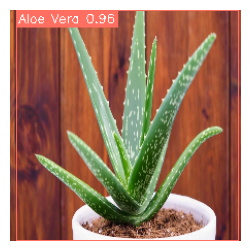


Processing peace_lily.jpg:


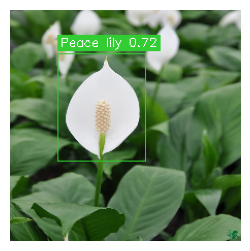


Processing monstera_deliciosa.jpg:


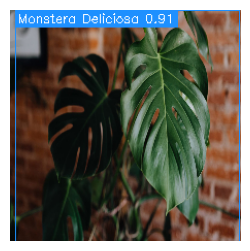

In [91]:
for image_path in image_paths:
    print(f"\nProcessing {image_path}:")
    results = predict_plant(image_path)